modules

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from math import radians, sin, cos, asin, sqrt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.projections
plotdir = 'plots/'

sample locations and metadata

In [147]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %1
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))
        
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)

group = np.array([i[2] for i in metadata])[order]
population_names, population_ixs = np.unique(group, return_inverse=True)

locations = np.array([list(map(float,[i[7].replace(',','.'),i[6].replace(',','.')])) for i in metadata])[order]
# locations = np.load('../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_locations.npy')

ancestor locations

In [148]:
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus
tCutoffs = ['None',int(1e6),int(1e5),int(1e4)]

In [161]:
# tCutoff = int(1e5)
tCutoff = int(1e4)

ancestor_times = np.linspace(1e3,tCutoff,10)
ancestor_times = np.hstack([0,ancestor_times]) #we started with the sample location

string = '../data/T2T_Athaliana_66.Chr*.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'%(Ne,m,numiter,threshold) + '_*bps_%dnsamples_%dtCutoff_anc-locs_full-trees.npy'%(nsamples, tCutoff)

anc_locs = []
for fn in glob.iglob(string):
    anc_locs.append(np.load(fn))

anc_locs = np.array(anc_locs)

L, n, T, d = anc_locs.shape
L, n, T, d

(878, 66, 11, 2)

# Plots

## sample locations

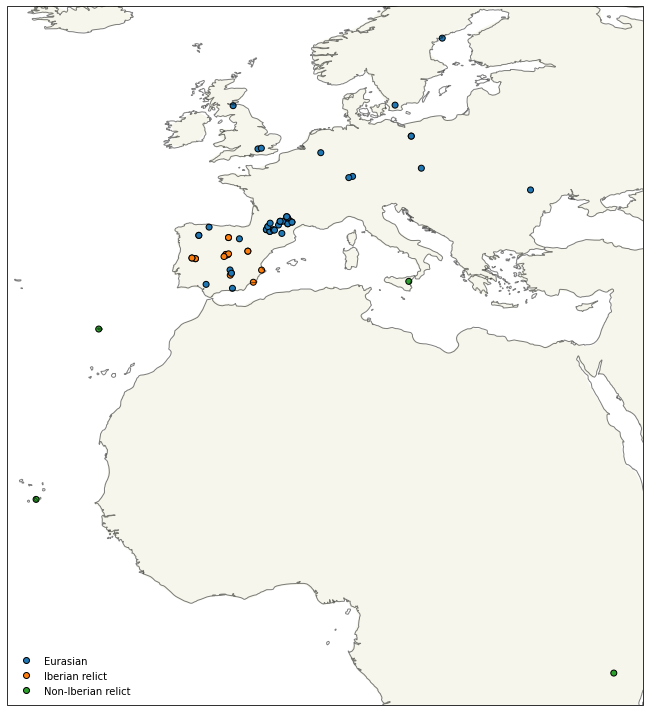

In [170]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection=ccrs.PlateCarree())

cmap = plt.cm.tab10
ax.scatter(locations[:,0], locations[:,1], transform=ccrs.PlateCarree(), color=cmap(population_ixs), edgecolor='k', zorder=1)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles = [plt.Line2D((0,1),(0,0), color=cmap(i), marker='o', linestyle='', markeredgecolor='k') for i in range(3)]
plt.legend(handles, population_names, loc='lower left', frameon=False)

plt.tight_layout()
# plt.savefig(plotdir + 'locations.pdf')
plt.show()

## dispersal rates

In [149]:
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%stCutoff_mle-dispersal.npy'

In [150]:
mles = []
for T in tCutoffs:
    mle = np.load(fname %T, allow_pickle=True)
    mles.append(mle)

In [151]:
meanlon = np.mean(locations[:,0])

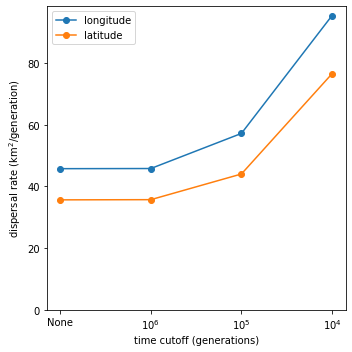

In [155]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(range(len(mles)), [mle[0]**2 * 110**2 for mle in mles], label='longitude', marker='o')
ax.plot(range(len(mles)), [mle[1]**2 * (np.cos(meanlon * np.pi/180)*111)**2 for mle in mles], label='latitude', marker='o')

xticks = range(len(mles))
xlabels = ['None', '$10^6$', '$10^5$', '$10^4$']
plt.xticks(xticks, xlabels)
plt.xlabel('time cutoff (generations)')

ax.set_ylim(ymin=0)
ax.set_ylabel(r'dispersal rate ($\mathrm{km}^2/\mathrm{generation}$)')
ax.legend()

plt.tight_layout()
# plt.savefig(plotdir + 'dispersal-rates.pdf')
plt.show()

## mean displacements

get mean ancestor locations

In [162]:
time_ix = -1 #choose which time to get ancestor locations at

disps = []
for sample in range(n):

    locs = anc_locs[:,sample,time_ix]
#     row_mask = (locs != locations[sample]).all(axis=1)
#     locs = locs[row_mask,:] #exclude subtrees that contain only the sample
    mean_loc = np.mean(locs, axis=0)
    disp = mean_loc - locations[sample]
    disps.append(disp)

In [163]:
def haversine(loc1, loc2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [loc1[0], loc1[1], loc2[0], loc2[1]])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

get mean displacement distances

In [164]:
dists = [haversine(locations[i], disp) for i,disp in enumerate(disps)]
relative_dists = dists/np.max(dists)

color by distance

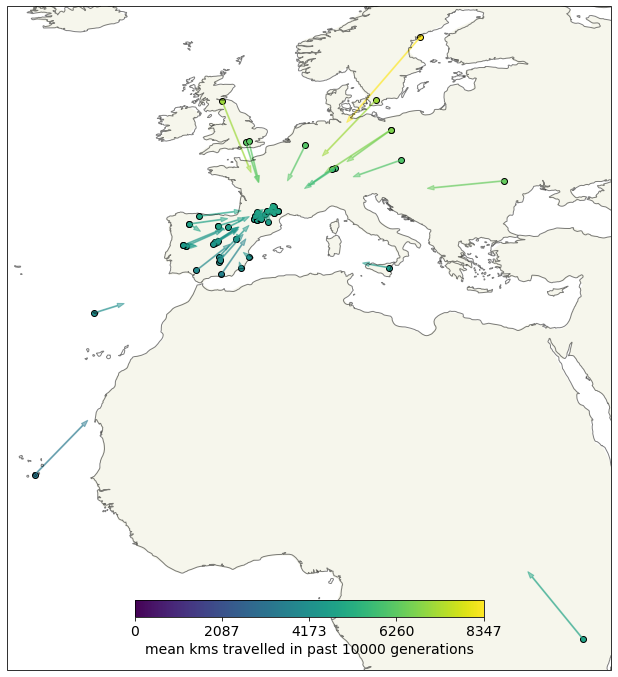

In [165]:
# plot map
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
    
for i,disp in enumerate(disps):
    
    cmap = plt.get_cmap('viridis')
    color = cmap(relative_dists[i])
#     color = plt.cm.tab10(population_ixs[i])
    ax.scatter(locations[i,0], locations[i,1], color=color, edgecolor='k', zorder=0)
    ax.arrow(locations[i,0], locations[i,1], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.5, length_includes_head=True, width=0.1, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap=cmap), ax=ax, orientation='horizontal', pad=-0.1, shrink=0.5)
cbar.set_ticks([i/4 for i in range(5)])
cbar.set_ticklabels([round(i*max(dists)/4) for i in range(5)])
cbar.set_label('mean kms travelled in past %d generations' %int(ancestor_times[time_ix]), fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

plt.show()

could also color by pca group

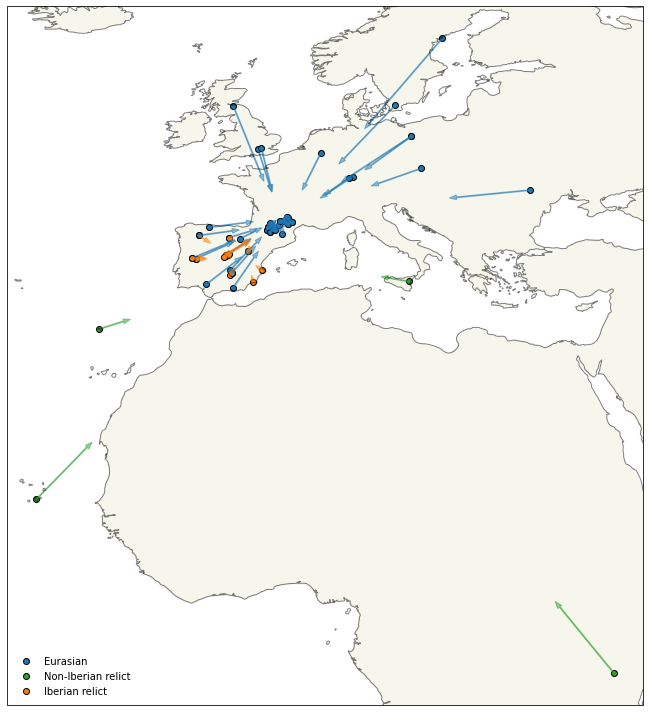

In [167]:
# plot map
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
    
for i,disp in enumerate(disps):
    
    color = plt.cm.tab10(population_ixs[i])
    ax.scatter(locations[i,0], locations[i,1], color=color, edgecolor='k', zorder=0, label=group[i])
    ax.arrow(locations[i,0], locations[i,1], disp[0], disp[1], transform=ccrs.PlateCarree(),
             head_width=0.5, length_includes_head=True, width=0.1, alpha=0.5, color=color)

ax.coastlines(resolution='50m', alpha=0.5)
ax.add_feature(cfeature.LAND, alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left', frameon=False)

plt.tight_layout()

# plt.savefig(plotdir + 'mean-displacements.pdf')
plt.show()

this nicely shows that most Iberian relicts stay put, relative to Eurasians in Spain

## ancestor clouds

In [232]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def ancestor_clouds(sample, extent=None, time_ixs = range(8,11), levels=10, bw_adjust=1, filename=None):
    
    cmap = cmaps[population_ixs[sample]]

    fig, axs = plt.subplots(1,len(time_ixs),figsize=(5*len(time_ixs), 5),subplot_kw={'projection': ccrs.PlateCarree()})

    print(ids[sample])
    for ax,time_ix in zip(axs,time_ixs):
        
        print(int(ancestor_times[time_ix]))
        
        locs = anc_locs[:,sample,time_ix]
#         row_mask = (locs != locations[sample]).all(axis=1)
#         locs = locs[row_mask,:] #exclude subtrees that contain only the sample
    
        sns.kdeplot(x=locs[:,0], y=locs[:,1], transform=ccrs.PlateCarree(), ax=ax, levels=levels, color=plt.cm.tab10(population_ixs[sample]), bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap
        ax.scatter(locs[:,0], locs[:,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs[sample]), alpha=0.1)

        ax.scatter(locations[sample,0], locations[sample,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs[sample]), edgecolor='k')
#         ax.scatter(locations[:,0], locations[:,1], transform=ccrs.PlateCarree(), color=plt.cm.tab10(population_ixs), alpha=0.1)
        
#         ax.set_title(int(ancestor_times[time_ix]))
        ax.coastlines(resolution='50m', alpha=0.5)
        ax.add_feature(cfeature.LAND, alpha=0.5)
        
        if extent is not None:
            ax.set_extent(extent, crs=ccrs.PlateCarree())

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

an interesting example from each PCA group

rapid south-north migration in Eurasians

6137
1000
5000
10000


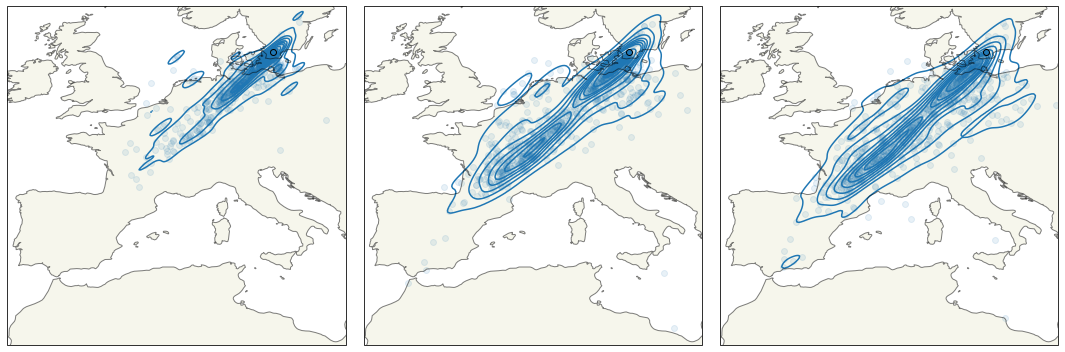

In [233]:
extent = [-10,20,30,60]
filename = plotdir + 'sample0-cloud.pdf'
# filename = None
ancestor_clouds(0, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

lots of Eurasian ancestry in this Iberian relict

Met-6
1000
5000
10000


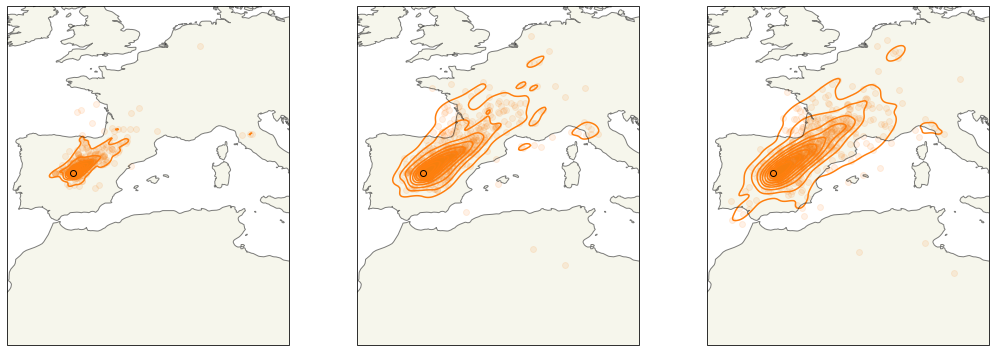

In [234]:
extent = [-10,15,25,55]
filename = plotdir + 'sample59-cloud.pdf'
# filename = None
ancestor_clouds(59, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

very varied ancestry in this Iberian relict, including lots of non-Iberian relict relations

Hum-2
1000
5000
10000


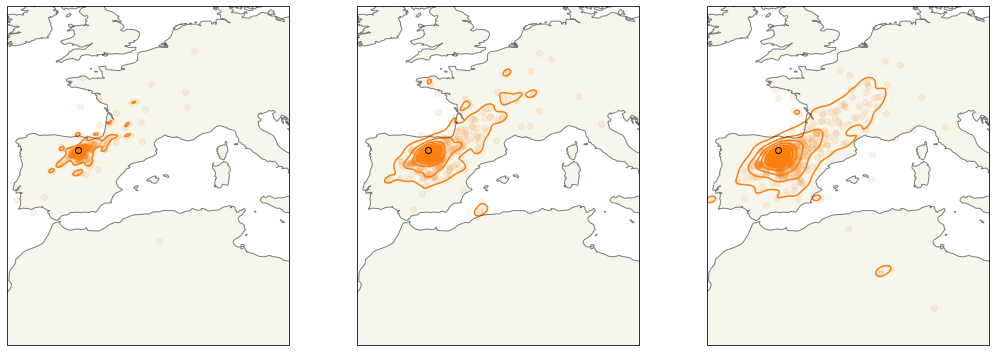

In [236]:
extent = [-10,15,25,55]
filename=plotdir + 'sample39-cloud.pdf'
# filename = None
ancestor_clouds(39, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

rapid migration of non-Iberian relicts

Cvi-0
1000
5000
10000


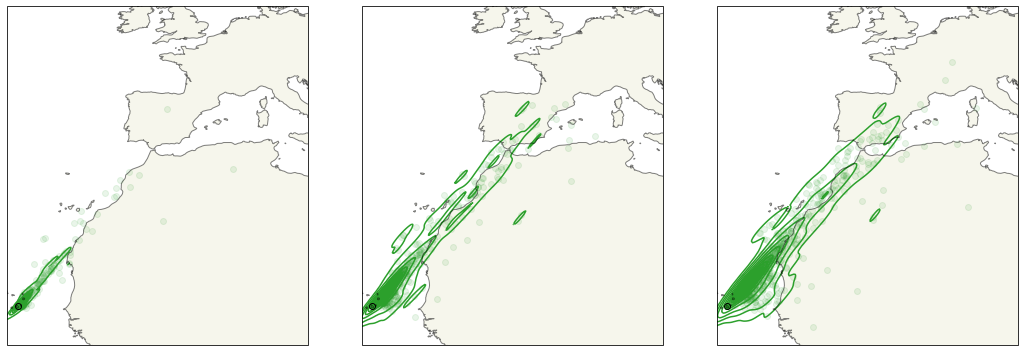

In [237]:
extent = [-25,15,10,55]
filename=plotdir + 'sample20-cloud.pdf'
# filename = None
ancestor_clouds(20, extent=extent, bw_adjust=0.75, time_ixs = [1,5,10], filename=filename)

## 2d histograms

also extended to combine samples together

In [238]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def map_hist(groups, extent=None, time_ixs = [1,5,10], levels=10, bw_adjust=1, filename=None):

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    for time_ix in time_ixs:
        print(int(ancestor_times[time_ix]))

        plt.figure(1, figsize=(8, 8))
        axScatter = plt.axes(rect_scatter, projection=ccrs.PlateCarree())
        axHistx = plt.axes(rect_histx)
        axHisty = plt.axes(rect_histy)
        
        for group in groups:

            all_locs = np.empty((1,2))
            for sample in group: 

                locs = anc_locs[:,sample,time_ix]
#                 row_mask = (locs != locations[sample]).all(axis=1)
#                 locs = locs[row_mask,:] #exclude subtrees that contain only the sample
                all_locs = np.vstack([all_locs, locs])
            all_locs = all_locs[1:] #drop the empty row
            
#             axScatter.scatter(x=all_locs[:,0], y=all_locs[:,1], transform=ccrs.PlateCarree())
            sns.kdeplot(x=all_locs[:,0], y=all_locs[:,1], transform=ccrs.PlateCarree(), ax=axScatter, levels=levels, bw_adjust=bw_adjust, zorder=0)#fill=True, , cmap=cmap

#             axHistx.hist(all_locs[:,0], bins=50, density=True, alpha=0.5)
            sns.kdeplot(x=all_locs[:,0], ax=axHistx, bw_adjust=bw_adjust, fill=True)
#             axHisty.hist(all_locs[:,1], bins=50, orientation='horizontal', density=True, alpha=0.5)
            sns.kdeplot(y=all_locs[:,1], ax=axHisty, bw_adjust=bw_adjust, fill=True)

        axScatter.coastlines(resolution='50m', alpha=0.5)
        axScatter.add_feature(cfeature.LAND, alpha=0.5)

        if extent is not None:
            axScatter.set_extent(extent, crs=ccrs.PlateCarree())
        
        axHistx.set_xlim(axScatter.get_xlim())
        axHisty.set_ylim(axScatter.get_ylim())
        nullfmt = NullFormatter()         # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.set(ylabel=None) 
        axHisty.set(xlabel=None)
        
        plt.tight_layout()
        
        if filename is not None:
            plt.savefig(filename + '-' + str(time_ix) + '.pdf')

        plt.show()

look at all the ancestors of each PCA group

1000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


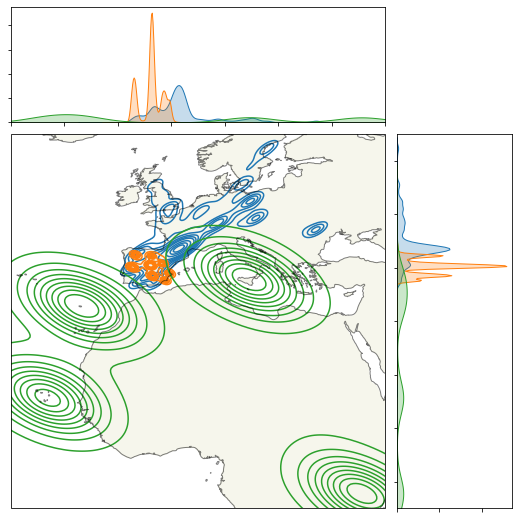

5000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


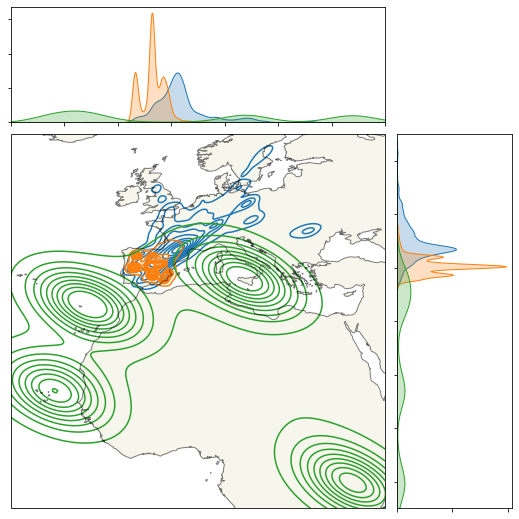

10000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


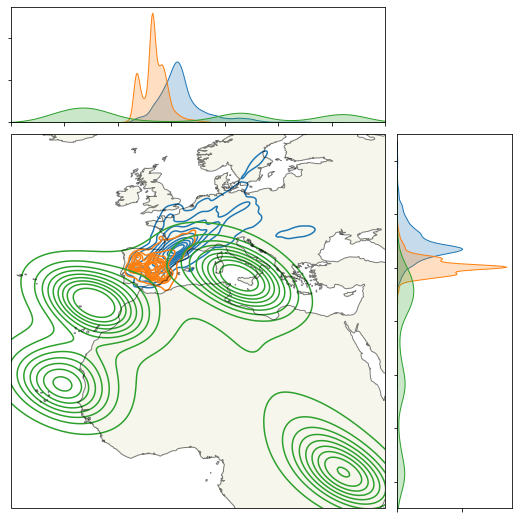

In [247]:
extent = [-30,40,-5,65] #subplots only lining up when square
filename = plotdir + 'pca-clouds'
# filename = None
map_hist([np.where(population_ixs==0)[0], np.where(population_ixs==1)[0], np.where(population_ixs==2)[0]], filename=filename, extent=extent)

compare relict vs non relict in spain

In [248]:
group1 = []
for i in range(n):
    if locations[i,0]>-10 and locations[i,0]<0 and locations[i,1]>36 and locations[i,1]<45 and population_ixs[i]==0:
        group1.append(i)

1000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


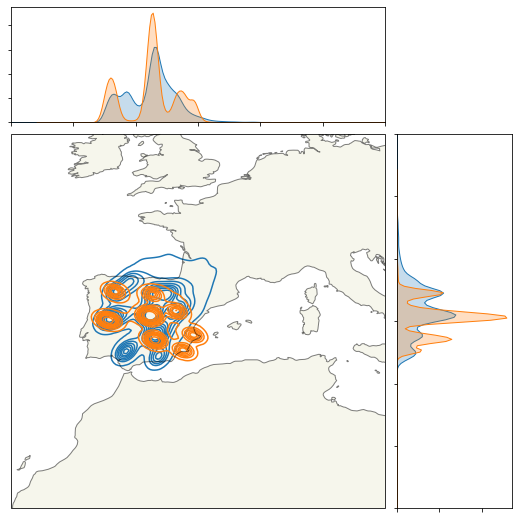

5000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


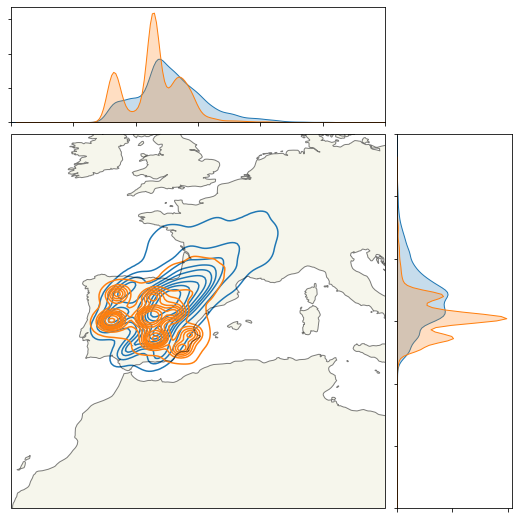

10000


/tmp/ipykernel_52690/2320847629.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


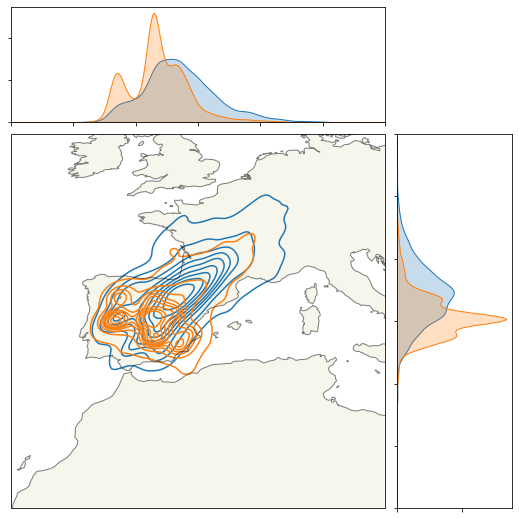

In [249]:
extent = [-15,15,25,55]
# extent=None
filename = plotdir + 'relict-vs-nonrelict-clouds'
# filename = None
map_hist([group1, np.where(population_ixs==1)[0]], extent=extent, filename=filename)

notice the Eurasian lineages move further north and east relative to Iberian relicts, but lots of variation

## Windroses

In [250]:
cmaps = [plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens] #to roughly align with color scheme above

def polar_plot(bearings, ax=None, n=36, color='k'):

    bins = np.arange(n + 1) * 360 / n
    width =  2 * np.pi / n

    frequencies, division = np.histogram(bearings, bins=bins, density=True)
    division = division[:-1]
    xs = division * np.pi / 180
        
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes(polar=True)
        
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')    
        
    bars = ax.bar(xs, frequencies, width=width, align='center', zorder=2, edgecolor='k', linewidth=0.5, alpha=0.7, color=color)
#     sns.kdeplot(x=bearings* np.pi / 180, ax=ax, fill=True, color=color, bw_adjust=0.5)
#     ax.set_ylabel(None)

    ax.set_yticklabels(labels=[])
    ax.set_xticklabels(labels=[])
    
def windrose(sample, extent=None, time_ix=-1, filename=None):
    
    print(ids[sample])
    int(ancestor_times[time_ix])
    
    # set up plot
    fig = plt.figure(figsize=(10, 10))
    plateCr = ccrs.PlateCarree()
    plateCr._threshold = plateCr._threshold/100.  #set finer threshold for smoother great circle lines
    ax = plt.axes(projection=plateCr)

    # get ancestor locations
    locs = anc_locs[:,sample,time_ix]
#     row_mask = (locs != locations[sample]).all(axis=1)
#     locs = locs[row_mask,:] #exclude subtrees that contain only the sample

    # plot the displacement at each locus as great circle
    for loc in locs:
        lons = np.vstack([locations[sample,0],loc[0]])
        lats = np.vstack([locations[sample,1],loc[1]])
        ax.plot(lons, lats, transform=ccrs.Geodetic(), color=plt.cm.tab10(population_ixs[sample]), alpha=0.5)

    # windrose inset
    geodesic = pyproj.Geod(ellps='WGS84')
    L,d = locs.shape
    bearings = np.zeros(L)
    distances = np.zeros(L)
    for i,(long,lat) in enumerate(locs):
        az1,_,d = geodesic.inv(locations[sample,0],locations[sample,1], long, lat)
        if az1 < 0:
            az1 = 360 + az1
        bearings[i] = az1
        distances[i] = d
    inset_ax = inset_axes(ax, bbox_to_anchor=(locations[sample,0],locations[sample,1]), bbox_transform=ax.transData, 
                          width=1, height=1, loc='center', axes_class=matplotlib.projections.get_projection_class('polar'))
    polar_plot(ax=inset_ax, bearings=bearings, color=plt.cm.tab10(population_ixs[sample]))
    
    # styling
#     ax.set_title(int(ancestor_times[time_ix]))
    ax.coastlines(resolution='50m', alpha=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.5)
    if extent is not None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

here is the Iberian relict with lots of non-Iberian relict relations

Hum-2


/tmp/ipykernel_52690/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


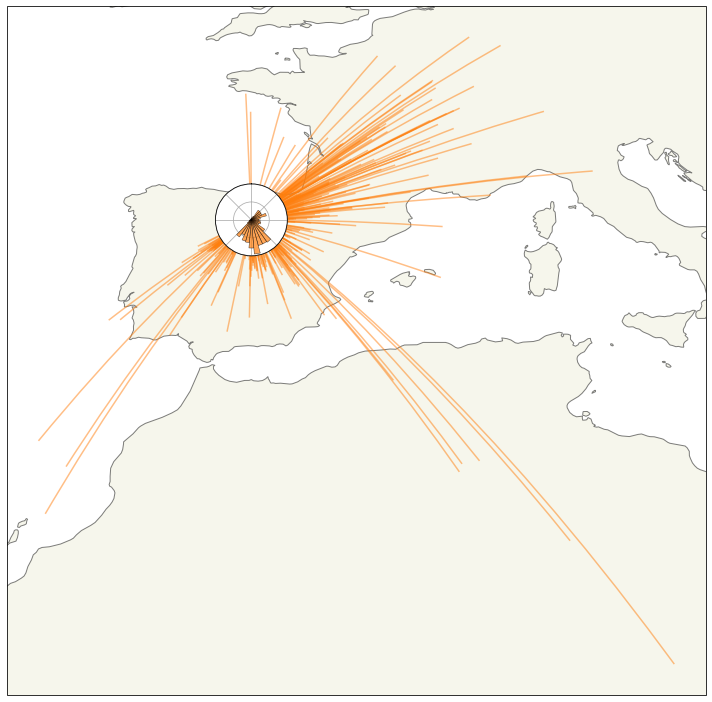

In [251]:
filename = plotdir + 'windrose39.pdf'
# filename = None
windrose(39, filename=filename)

and compare to a Spanish Eurasian

9883


/tmp/ipykernel_52690/2641269890.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


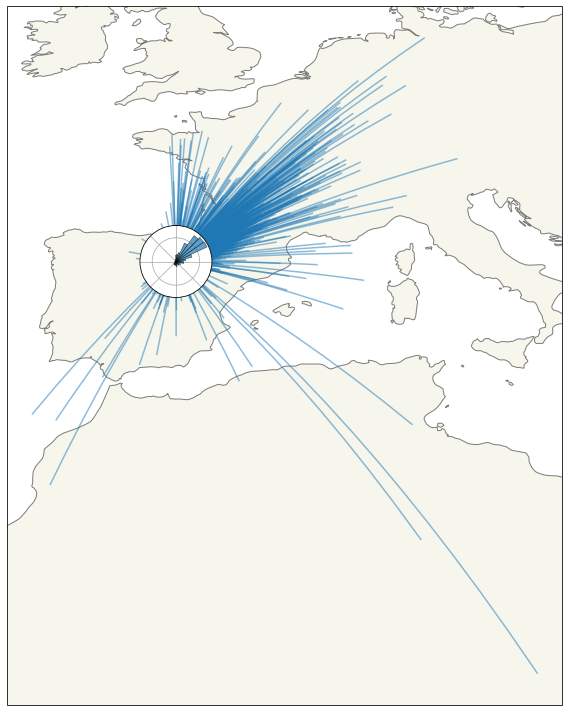

In [252]:
filename = plotdir + 'windrose14.pdf'
# filename = None
windrose(14, filename=filename)